# Simulating pET19KT [MaSp2]32 Production Limits (Four Repeats)

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## 4. Create the MaSp2 Transcription Reaction

Complete the steps necessary to create the MaSp2 Transcription Reaction

In [4]:
locus_id = 'MaSp2'
left_pos =  None
right_pos = None
seq = 'ATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGAGGG'
strand = None
rna_type = 'mRNA'

building.create_transcribed_gene(me, locus_id, rna_type, seq)
building.add_transcription_reaction(me, 'TU_MaSp2', {'MaSp2'}, seq)
print(me.reactions.transcription_TU_MaSp2.reaction)
me.reactions.transcription_TU_MaSp2.update()

549 atp_c + 1570 ctp_c + 1218 gtp_c + 767 utp_c --> RNA_MaSp2 + 1311.0214523240002 mRNA_biomass + 4104 ppi_c


/source/cobrame/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found


###  Add the RNAP to the MaSp1 Transcription Reaction

In [5]:
me.reactions.transcription_TU_MaSp2.transcription_data.RNA_polymerase = 'RNAP70-CPLX'
me.reactions.transcription_TU_MaSp2.update()

List the transcription data ("transcription_data") associated with the MaSp2 transcription reaction ("transcription_TU_MaSp2").

In [6]:
rxn = me.reactions.transcription_TU_MaSp2
data = rxn.transcription_data
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,TU_MaSp2
_model,iJL1678b-ME
_parent_reactions,{'transcription_TU_MaSp2'}
nucleotide_sequence,ATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCC...
RNA_products,{'RNA_MaSp2'}
RNA_polymerase,RNAP70-CPLX
subreactions,"defaultdict(<class 'int'>, {})"


List the attributes of the MaSp2 transcription reaction.

In [7]:
rxn = me.reactions.transcription_TU_MaSp2
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,transcription_TU_MaSp2
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,"{<RNAP RNAP70-CPLX at 0x7faee160f390>: -0.0196124982794219*mu - 0.00767829307639367, <TranscribedGene RNA_MaSp2 at 0x7faee173ad30>: 1, <Metabolite utp_c at 0x7faee160fe10>: -767, <Metabolite atp_c at 0x7faee160f9b0>: -549, <Metabolite ctp_c at 0x7faee160fef0>: -1570, <Metabolite gtp_c at 0x7faee..."
_model,iJL1678b-ME
_objective_coefficient,0.0


List the complete reaction associated with the MaSp1 transcription reaction.

In [8]:
me.reactions.get_by_id('transcription_TU_MaSp2').reaction

'0.0196124982794219*mu + 0.00767829307639367 RNAP70-CPLX + 549 atp_c + 1570 ctp_c + 1218 gtp_c + 767 utp_c --> RNA_MaSp2 + 1311.0214523240002 mRNA_biomass + 4104 ppi_c'

List the RNAP associated with the MaSp2 transcription reaction

In [9]:
me.reactions.transcription_TU_MaSp2.transcription_data.RNA_polymerase

'RNAP70-CPLX'

## 5. Create the MaSp2 Translation Reaction

Complete all the steps necessary to create the MaSp2 Translation Reaction

### Storing information about a translation reaction

In [10]:
data = cobrame.TranslationData('MaSp2', me, 'RNA_MaSp2', 'protein_MaSp2')
data.nucleotide_sequence = seq

### Create translation reaction

By associating the TranslationReaction with its corresponding TranslationData object and running the update function, COBRAme will create a translation reaction for the nucleotide sequence given based on the organisms codon table and prespecified translation machinery.

In [11]:
rxn = cobrame.TranslationReaction('translation_MaSp2')
rxn.translation_data = data
me.add_reaction(rxn)

### Updating the translation reaction

Note that this process does not include the ribosome in the reaction.

In [12]:
rxn.update()
print(rxn.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 6.13480109739369*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 506 gly_c + 7.84095134723271*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 236 pro__L_c + 0.0196124982794219*mu + 0.00767829307639367 ribosome + 76 ser__L_c + thr__L_c + 68 tyr__L_c --> 6.13480109739369*(mu + 0.3915)/mu adp_c + 3.28345679012346*(mu + 0.3915)/mu amp_c + 9.38984910836763*(mu + 0.3915)/mu cmp_c + 7.28460905349794*(mu + 0.3915)/mu gmp_c + 1367.0 - 6.13480109739369*(mu + 0.3915)/mu h2o_c + 6.13480109739369*(mu + 0.3915)/mu h_c + 6.13480109739369*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 114.82236754 protein_biomass + 4.58727023319616*(mu + 0.3915)/mu ump_c


### Incorporate the ribosome

Add the ribosome to the reaction.

In [13]:
ribosome = cobrame.Ribosome('ribosome')
me.add_metabolites([ribosome])
me.reactions.translation_MaSp2.update()
print(me.reactions.translation_MaSp2.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 6.13480109739369*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 506 gly_c + 7.84095134723271*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 236 pro__L_c + 0.0196124982794219*mu + 0.00767829307639367 ribosome + 76 ser__L_c + thr__L_c + 68 tyr__L_c --> 6.13480109739369*(mu + 0.3915)/mu adp_c + 3.28345679012346*(mu + 0.3915)/mu amp_c + 9.38984910836763*(mu + 0.3915)/mu cmp_c + 7.28460905349794*(mu + 0.3915)/mu gmp_c + 1367.0 - 6.13480109739369*(mu + 0.3915)/mu h2o_c + 6.13480109739369*(mu + 0.3915)/mu h_c + 6.13480109739369*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 114.82236754 protein_biomass + 4.58727023319616*(mu + 0.3915)/mu ump_c


### Add Subreactions to the MaSp2 model

Create the subreactions that represent elongation, initiation and termination

In [14]:
elongation = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
initiation = ['Translation_gtp_initiation_factor_InfB', 'Translation_initiation_factor_InfA', 
              'Translation_initiation_factor_InfC', 'fmet_addition_at_START', 'peptide_deformylase_processing', 
              'peptide_chain_release', 'ribosome_recycler']
termination = {'UGA':'PrfB_mono'}
me.process_data.get_by_id('MaSp2').add_elongation_subreactions(elongation_subreactions=set(elongation))
me.process_data.get_by_id('MaSp2').add_initiation_subreactions(start_codons=set(['AUG']), start_subreactions=set(initiation))
me.process_data.get_by_id('MaSp2').add_termination_subreactions(translation_terminator_dict=termination)
#me.reactions.translation_MaSp2.update(verbose=False)

/source/cobrame/cobrame/core/processdata.py:896 UserWarning: No termination enzyme for RNA_MaSp2


List the subreactions associated with MaSp2 translation reaction stored in the ProcessData.

In [15]:
me.process_data.get_by_id('MaSp2').subreactions

defaultdict(int,
            {'Tuf_gtp_regeneration': 1367.0,
             'FusA_mono_elongation': 1367.0,
             'thr_addition_at_ACC': 1,
             'gly_addition_at_GGU': 252,
             'pro_addition_at_CCG': 56,
             'gln_addition_at_CAG': 88,
             'tyr_addition_at_UAU': 28,
             'pro_addition_at_CCU': 80,
             'gly_addition_at_GGC': 84,
             'gly_addition_at_GGA': 121,
             'ser_addition_at_AGC': 20,
             'ser_addition_at_AGU': 16,
             'ala_addition_at_GCA': 156,
             'ala_addition_at_GCU': 44,
             'ala_addition_at_GCC': 48,
             'gln_addition_at_CAA': 104,
             'pro_addition_at_CCA': 72,
             'tyr_addition_at_UAC': 40,
             'ser_addition_at_UCA': 16,
             'ala_addition_at_GCG': 40,
             'pro_addition_at_CCC': 28,
             'gly_addition_at_GGG': 48,
             'ser_addition_at_UCU': 20,
             'ser_addition_at_UCC': 4,
           

List the subreactions generated from the nucleatide sequence that are stored in the ProcessData.

In [16]:
me.process_data.get_by_id('MaSp2').subreactions_from_sequence

{'thr_addition_at_ACC': 1,
 'gly_addition_at_GGU': 252,
 'pro_addition_at_CCG': 56,
 'gln_addition_at_CAG': 88,
 'tyr_addition_at_UAU': 28,
 'pro_addition_at_CCU': 80,
 'gly_addition_at_GGC': 84,
 'gly_addition_at_GGA': 121,
 'ser_addition_at_AGC': 20,
 'ser_addition_at_AGU': 16,
 'ala_addition_at_GCA': 156,
 'ala_addition_at_GCU': 44,
 'ala_addition_at_GCC': 48,
 'gln_addition_at_CAA': 104,
 'pro_addition_at_CCA': 72,
 'tyr_addition_at_UAC': 40,
 'ser_addition_at_UCA': 16,
 'ala_addition_at_GCG': 40,
 'pro_addition_at_CCC': 28,
 'gly_addition_at_GGG': 48,
 'ser_addition_at_UCU': 20,
 'ser_addition_at_UCC': 4}

### Updating the MaSp2 translation reaction

In [17]:
translation_subreactions = me.process_data.MaSp2.subreactions_from_sequence
print("Before adding tRNA subreaction")
print("------------------------------")
print(me.reactions.translation_MaSp2.reaction)
print("")
# Link tranlation_data to subreactions and update
for subreaction, value in translation_subreactions.items():
    me.process_data.MaSp2.subreactions[subreaction] = value
me.reactions.translation_MaSp2.update(verbose=False)
print("After adding tRNA subreaction")
print("-----------------------------")
print(me.reactions.translation_MaSp2.reaction)

Before adding tRNA subreaction
------------------------------
0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 6.13480109739369*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 506 gly_c + 7.84095134723271*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 236 pro__L_c + 0.0196124982794219*mu + 0.00767829307639367 ribosome + 76 ser__L_c + thr__L_c + 68 tyr__L_c --> 6.13480109739369*(mu + 0.3915)/mu adp_c + 3.28345679012346*(mu + 0.3915)/mu amp_c + 9.38984910836763*(mu + 0.3915)/mu cmp_c + 7.28460905349794*(mu + 0.3915)/mu gmp_c + 1367.0 - 6.13480109739369*(mu + 0.3915)/mu h2o_c + 6.13480109739369*(mu + 0.3915)/mu h_c + 6.13480109739369*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 114.82236754 protein_biomass + 4.58727023319616*(mu + 0.3915)/mu ump_c

After adding tRNA subreaction
-----------------------------
10fthf_c + 2.72438972852433e-7*mu Def_mono_mod_1:fe2 + 1.80324164444648e-7

List the reactants associated with the MaSp2 translation reaction. In this list all the subreactions should be listed.

In [18]:
me.reactions.translation_MaSp2.reactants

[<Metabolite met__L_c at 0x7faee09119b0>,
 <Metabolite h2o_c at 0x7faee160fa58>,
 <Metabolite thr__L_c at 0x7faee0911e10>,
 <Metabolite gly_c at 0x7faee0911cf8>,
 <Metabolite pro__L_c at 0x7faee091e2e8>,
 <Metabolite gln__L_c at 0x7faee091e278>,
 <Metabolite tyr__L_c at 0x7faee091e470>,
 <Metabolite ser__L_c at 0x7faee0911eb8>,
 <Metabolite ala__L_c at 0x7faee0911f60>,
 <Ribosome ribosome at 0x7faee091e550>,
 <TranscribedGene RNA_MaSp2 at 0x7faee173ad30>,
 <Metabolite atp_c at 0x7faee160f9b0>,
 <Complex RNA_degradosome at 0x7faee1636400>,
 <Complex Tsf_mono at 0x7faee0938c50>,
 <Complex FusA_mono at 0x7faee0938c18>,
 <Metabolite gtp_c at 0x7faee160ffd0>,
 <GenericComponent generic_Tuf at 0x7faee091ea58>,
 <GenerictRNA generic_tRNA_ACC_thr__L_c at 0x7faee092f6d8>,
 <GenerictRNA generic_tRNA_GGU_gly_c at 0x7faee091ef60>,
 <GenerictRNA generic_tRNA_CCG_pro__L_c at 0x7faee092fd68>,
 <GenerictRNA generic_tRNA_CAG_gln__L_c at 0x7faee092f5f8>,
 <GenerictRNA generic_tRNA_UAU_tyr__L_c at 0x7fae

This completes the creation of the translation reaction

## 6. Create Demand Reaction for MaSp2

In [19]:
new_reaction = cobrame.MEReaction('DM_protein_MaSp2')
me.add_reaction(new_reaction)

In [20]:
me.reactions.get_by_id('DM_protein_MaSp2').reaction = 'protein_MaSp2 ->'
me.reactions.get_by_id('DM_protein_MaSp2').reaction

'protein_MaSp2 --> '

In [21]:
rxn = me.reactions.DM_protein_MaSp2
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,DM_protein_MaSp2
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,{<TranslatedGene protein_MaSp2 at 0x7faee1701ba8>: -1}
_model,iJL1678b-ME
_objective_coefficient,0.0


### Find the amino acid count

In [22]:
me.process_data.MaSp2.amino_acid_count

defaultdict(int,
            {'met__L_c': 1,
             'thr__L_c': 1,
             'gly_c': 506,
             'pro__L_c': 236,
             'gln__L_c': 192,
             'tyr__L_c': 68,
             'ser__L_c': 76,
             'ala__L_c': 288})

In [23]:
from contextlib import suppress

#me.reactions.DM_protein_MaSp1.upper_bound = 0.00015
#me.reactions.DM_protein_MaSp1.lower_bound = 0.00015
MaSp2 = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
growth_rate = []
for x in MaSp2:
    print('\nMaSp2 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp2').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp2').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate.append(temp)
    print('Growth-rate =', growth_rate)
    
growth_rate


MaSp2 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 36.307928 seconds
Finished substituting S,lb,ub in 2.226213 seconds
Finished makeME_LP in 0.365507 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.278897 seconds
Finished makeME_LP in 0.360025 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.294166 seconds
Finished makeME_LP in 0.355632 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.281812 seconds
Finished makeME_LP in 0.362641 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.299251 seconds
Finished makeME_LP in 0.372822 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.307965 seconds
Finished makeME_LP in 0.367781 seconds

2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.271087 seconds
Finished makeME_LP in 0.362872 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.270750 seconds
Finished makeME_LP in 0.356659 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.265833 seconds
Finished makeME_LP in 0.360385 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.282095 seconds
Finished makeME_LP in 0.367741 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.288362 seconds
Finished makeME_LP in 0.362394 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 494.968 seconds
Growth-rate = [0.828125, 0.796875, 0.6171875, 0, 0, 0, 0]


[0.828125, 0.796875, 0.6171875, 0, 0, 0, 0]

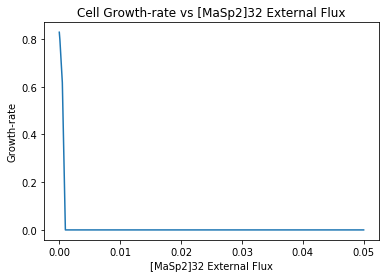

In [24]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs [MaSp2]32 External Flux')
  
# function to show the plot
plt.show()

In [25]:
from contextlib import suppress

#me.reactions.DM_protein_MaSp2.upper_bound = 0.00015
#me.reactions.DM_protein_MaSp2.lower_bound = 0.00015
MaSp2 = [0, 0.0001, 0.0005, 0.0006, 0.00061, 0.00062, 0.00063]
growth_rate2 = []
for x in MaSp2:
    print('\nMaSp2 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp2').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp2').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate2.append(temp)
    print('Growth-rate =', growth_rate2)
    
growth_rate2


MaSp2 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.795846 seconds
Finished substituting S,lb,ub in 2.249338 seconds
Finished makeME_LP in 0.353229 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.286859 seconds
Finished makeME_LP in 0.356719 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.312701 seconds
Finished makeME_LP in 0.360578 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.316304 seconds
Finished makeME_LP in 0.361116 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.286706 seconds
Finished makeME_LP in 0.358796 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.324373 seconds
Finished makeME_LP in 0.365268 seconds

1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 2.287190 seconds
Finished makeME_LP in 0.369353 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.267549 seconds
Finished makeME_LP in 0.366327 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.270929 seconds
Finished makeME_LP in 0.362690 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.274928 seconds
Finished makeME_LP in 0.359299 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.251627 seconds
Finished makeME_LP in 0.363953 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.255340 seconds
Finished makeME_LP in 0.366212 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 502.808 seconds
Growth-rat

[0.828125, 0.796875, 0.6171875, 0.53125, 0.5234375, 0.5078125, 0]

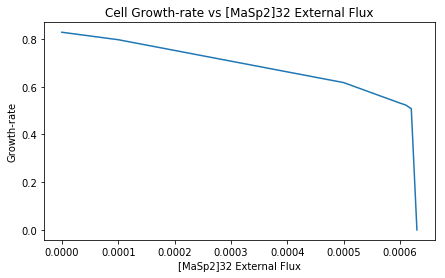

In [26]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2
# corresponding y axis values
y = growth_rate2

plt.figure(figsize=(7,4))
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs [MaSp2]32 External Flux')
  
# function to show the plot
plt.show()